Using device: cuda:2


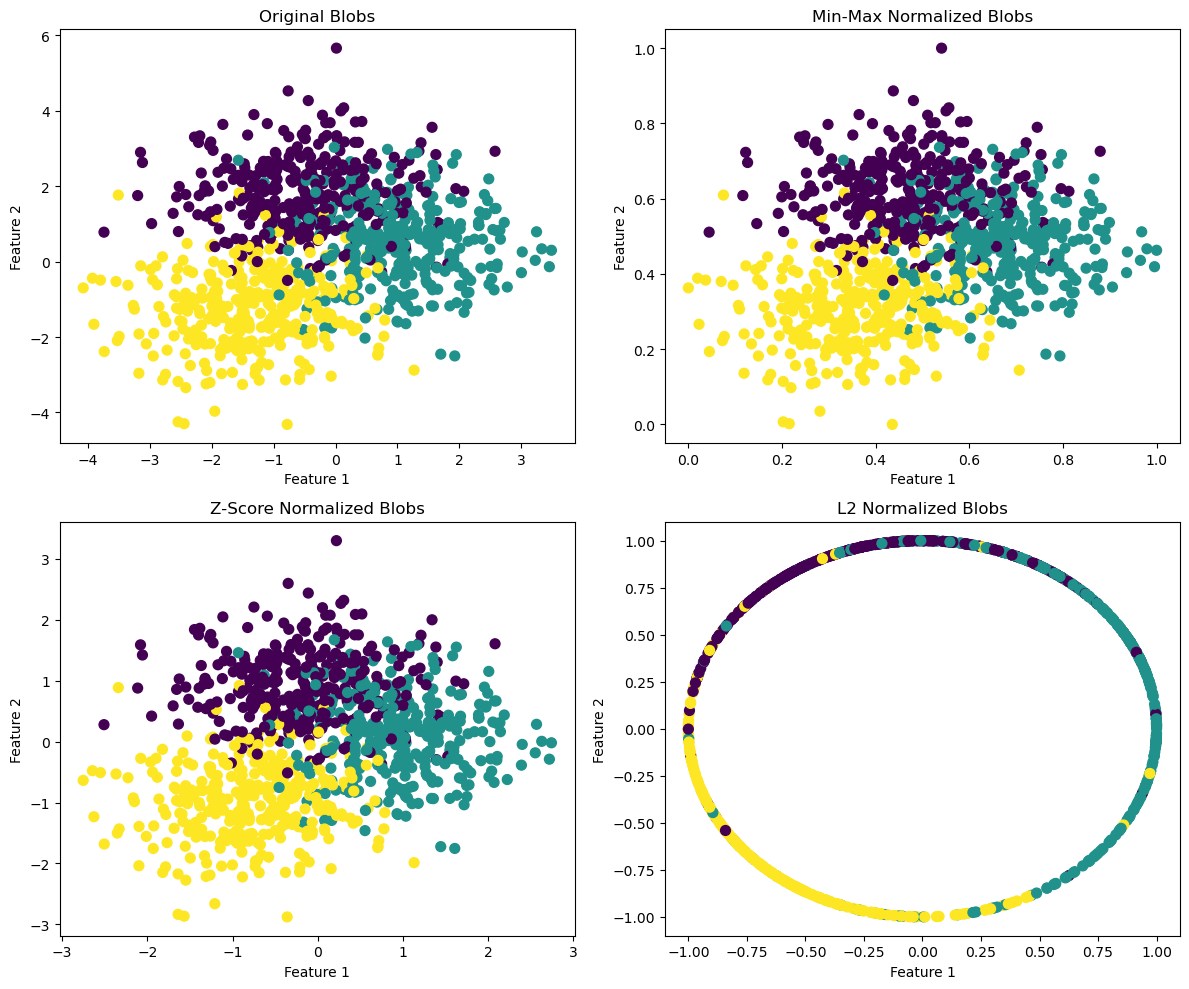

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler

#######################################
# 1) DEVICE SETUP
#######################################
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#######################################
# 2) SYNTHETIC DATASET (MULTICLASS)
#######################################
# Generate synthetic data (2D, 3 classes)
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=1.0, center_box=(-2, 2), random_state=42)

# Visualize the dataset
# plt.figure(figsize=(6, 6))
# plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap="coolwarm", s=10, alpha=0.8)
# plt.title("Synthetic Multiclass Dataset")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.show()

# Normalize the blobs
scaler_minmax = MinMaxScaler()
blobs_minmax = scaler_minmax.fit_transform(X)

scaler_zscore = StandardScaler()
blobs_zscore = scaler_zscore.fit_transform(X)

blobs_l2 = normalize(X, axis=1, norm='l2')

# Plot the original and normalized blobs
plt.figure(figsize=(12, 10))

# Original Blobs
plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50)
plt.title('Original Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Min-Max Normalized Blobs
plt.subplot(2, 2, 2)
plt.scatter(blobs_minmax[:, 0], blobs_minmax[:, 1], c=y, cmap='viridis', s=50)
plt.title('Min-Max Normalized Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Z-Score Normalized Blobs
plt.subplot(2, 2, 3)
plt.scatter(blobs_zscore[:, 0], blobs_zscore[:, 1], c=y, cmap='viridis', s=50)
plt.title('Z-Score Normalized Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# L2 Normalized Blobs
plt.subplot(2, 2, 4)
plt.scatter(blobs_l2[:, 0], blobs_l2[:, 1], c=y, cmap='viridis', s=50)
plt.title('L2 Normalized Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()
X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)

In [19]:
#######################################
# 3) MLP CLASSIFIER
#######################################
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 3)  # Output layer: 3 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model, optimizer, and loss function
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train-test split
train_idx = np.random.choice(len(X), int(0.8 * len(X)), replace=False)
test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

#######################################
# 4) TRAIN THE CLASSIFIER
#######################################
model.train()
for epoch in range(800):
    optimizer.zero_grad()
    logits = model(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

#######################################
# 5) VISUALIZE DECISION BOUNDARY AND ENERGY
#######################################
# Create a grid of points in the feature space
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min().cpu() - 1.0, X[:, 0].max().cpu() + 1.0, 100),
    np.linspace(X[:, 1].min().cpu() - 1.0, X[:, 1].max().cpu() + 1.0, 100)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

# Compute predictions and energy
T = 10
with torch.no_grad():
    logits = model(grid)
    probs = torch.softmax(logits, dim=1)
    energies = torch.log(probs + 1e-10)  # Avoid log(0)
    energy = -1 * T * torch.logsumexp(logits / T, dim=1).to('cpu').numpy().reshape(xx.shape)
    predictions = torch.argmax(probs, dim=1).cpu().numpy().reshape(xx.shape)


Epoch 20, Loss: 0.4566
Epoch 40, Loss: 0.3980
Epoch 60, Loss: 0.3830
Epoch 80, Loss: 0.3797
Epoch 100, Loss: 0.3776
Epoch 120, Loss: 0.3759
Epoch 140, Loss: 0.3741
Epoch 160, Loss: 0.3728
Epoch 180, Loss: 0.3717
Epoch 200, Loss: 0.3706
Epoch 220, Loss: 0.3696
Epoch 240, Loss: 0.3688
Epoch 260, Loss: 0.3680
Epoch 280, Loss: 0.3671
Epoch 300, Loss: 0.3661
Epoch 320, Loss: 0.3651
Epoch 340, Loss: 0.3641
Epoch 360, Loss: 0.3630
Epoch 380, Loss: 0.3619
Epoch 400, Loss: 0.3608
Epoch 420, Loss: 0.3597
Epoch 440, Loss: 0.3586
Epoch 460, Loss: 0.3570
Epoch 480, Loss: 0.3558
Epoch 500, Loss: 0.3542
Epoch 520, Loss: 0.3526
Epoch 540, Loss: 0.3504
Epoch 560, Loss: 0.3486
Epoch 580, Loss: 0.3461
Epoch 600, Loss: 0.3441
Epoch 620, Loss: 0.3443
Epoch 640, Loss: 0.3405
Epoch 660, Loss: 0.3389
Epoch 680, Loss: 0.3377
Epoch 700, Loss: 0.3357
Epoch 720, Loss: 0.3338
Epoch 740, Loss: 0.3330
Epoch 760, Loss: 0.3316
Epoch 780, Loss: 0.3298
Epoch 800, Loss: 0.3308


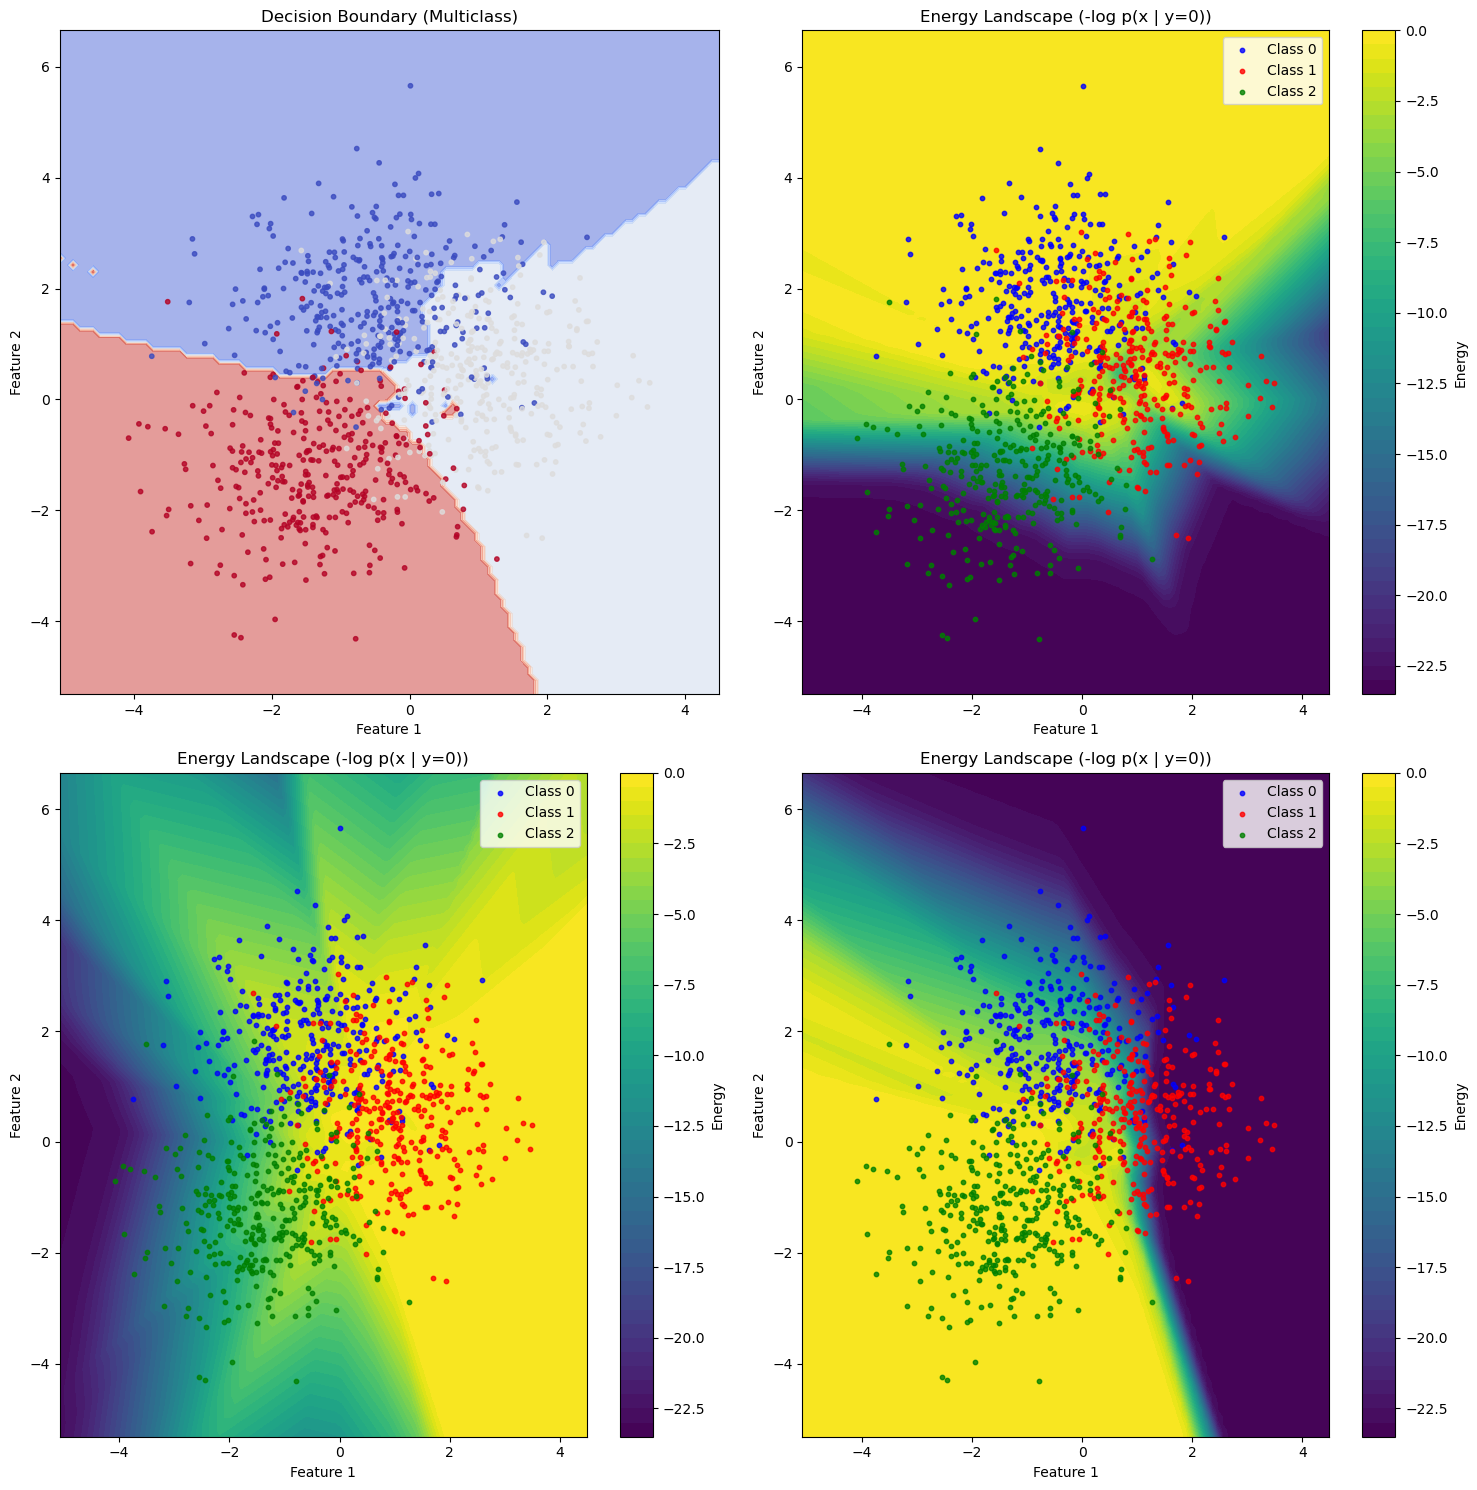

In [20]:
# Plot the decision boundary
plt.figure(figsize=(15, 15))

# Decision boundary
plt.subplot(2, 2, 1)
plt.contourf(xx, yy, predictions, alpha=0.5, cmap="coolwarm")
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap="coolwarm", s=10, alpha=0.8)
plt.title("Decision Boundary (Multiclass)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Energy landscape for class 0
plt.subplot(2, 2, 2)
energy_class_0 = energies[:, 0].cpu().numpy().reshape(xx.shape)
plt.contourf(xx, yy, energy_class_0, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.title("Energy Landscape (-log p(x | y=0))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Energy landscape for class 0
plt.subplot(2, 2, 3)
energy_class_1 = energies[:, 1].cpu().numpy().reshape(xx.shape)
plt.contourf(xx, yy, energy_class_1, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.title("Energy Landscape (-log p(x | y=0))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Energy landscape for class 0
plt.subplot(2, 2, 4)
energy_class_2 = energies[:, 2].cpu().numpy().reshape(xx.shape)
plt.contourf(xx, yy, energy_class_2, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.title("Energy Landscape (-log p(x | y=0))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

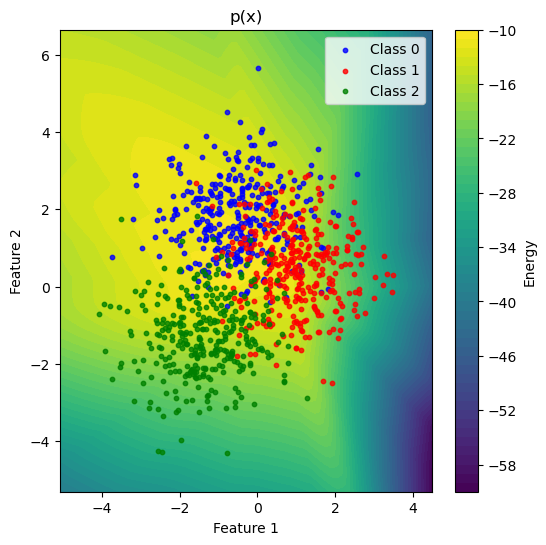

In [21]:
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.title("p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

In [22]:
import torch.nn.functional as F
import math

#######################################
# 5) ENERGY FUNCTION: E(x) = -log p(y|x)
#######################################
def energy_function(model, x, target_class):
    """
    x: Tensor of shape [1, 1, 28, 28].
    target_class: integer (0..9).
    Returns: scalar (the negative log-likelihood).
    """
    # Forward pass
    logits = model(x)
    energy = -1 * T * torch.logsumexp(logits / T, dim=1)
    # We pick the log-prob of 'target_class'
    return -1 * energy[0]

#######################################
# 6) LANGEVIN SAMPLING
#######################################
def langevin_sampling(model, target_class=0, step_size=0.02):
    """
    Use gradient-based MCMC (Langevin Dynamics) to sample an image x
    from the unnormalized density E(x) = -log p(target_class | x).

    Returns a single image of shape [1, 1, 28, 28].
    """
    # 6.1) Initialize x to random noise on the same device as model
    x = torch.rand((1, 2), device=device, requires_grad=True)
    x.data = -4 + (4 - (-4)) * x.data

    # i = 0
    j = 0
    # e = energy_function(model, x, target_class)
    
    while j < 100:
        # Zero-out gradient from previous step
        if x.grad is not None:
            x.grad.zero_()
        
        # Compute energy
        e = energy_function(model, x, target_class)
        
        # Backprop to get gradient
        e.backward()
        
        # Langevin update:
        with torch.no_grad():
            # x <- x - step_size * grad + noise
            x = x - (step_size / 2) * x.grad + math.sqrt(step_size) * torch.randn_like(x)
        
        # Detach from graph to avoid accumulating history
        x = x.detach()
        x.requires_grad_()
        
        # (Optional) print intermediate status
        if (j+1) % 50 == 0:
            print(f"  Step {j+1}, Energy: {-1 * e.item():.6f}")
        # i += 1
        j += 1
        # if i == 5000:
        #     if e.item() > 1e-3:
        #         i = i - 1
    return x.detach().cpu().numpy()

In [23]:
# Generate samples via Langevin dynamics
print("Generating samples in 2D space...")
samples = []
for idx in range(100):
    print('#########################################')
    samples.append(langevin_sampling(model))
    print('sample {} generated'.format(idx + 1))
    print('#########################################')

samples = np.concatenate(samples, axis=0)

Generating samples in 2D space...
#########################################
  Step 50, Energy: -10.888585
  Step 100, Energy: -11.134146
sample 1 generated
#########################################
#########################################
  Step 50, Energy: -16.291683
  Step 100, Energy: -13.155713
sample 2 generated
#########################################
#########################################
  Step 50, Energy: -17.443327
  Step 100, Energy: -11.877262
sample 3 generated
#########################################
#########################################
  Step 50, Energy: -10.849186
  Step 100, Energy: -10.927157
sample 4 generated
#########################################
#########################################
  Step 50, Energy: -14.559227
  Step 100, Energy: -14.834024
sample 5 generated
#########################################
#########################################
  Step 50, Energy: -25.335348
  Step 100, Energy: -11.298461
sample 6 generated
########################

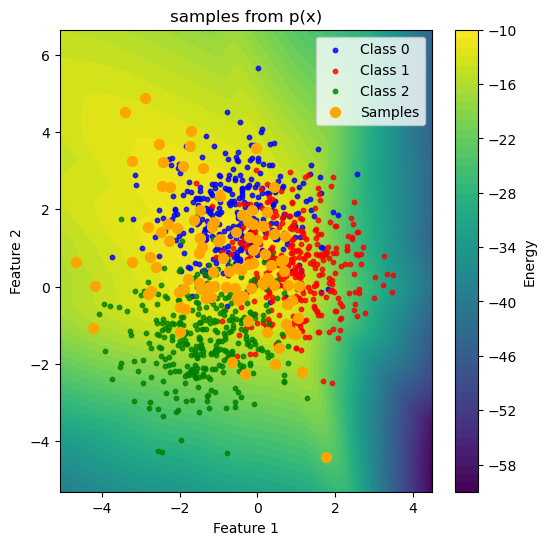

In [31]:
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.scatter(samples[:, 0], samples[:, 1], color="orange", s=50, alpha=1, label="Samples")
plt.title("samples from p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()